In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt

In [2]:
#!pip install keras
#!pip install tensorflow

In [3]:
df = pd.read_csv('stock-market-data-nifty-50-stocks-1-min-data/ACC_minute_data_with_indicators.csv')
df

,date,close,high,low,open,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 10:18:00+05:30,1544.00,1545.00,1543.10,1545.00,220,1544.94,1545.890,1546.756667,1546.9950,...,31.307634,0.000000,8.760123e+00,43.728004,-86.466165,2.056306,2.10,1544.033333,27.840336,0.138547
1,2015-02-02 10:19:00+05:30,1543.70,1544.00,1543.00,1544.00,29,1544.63,1545.545,1546.446667,1546.8650,...,23.381708,0.000000,4.380062e+00,47.390635,-89.629630,1.980855,1.00,1543.566667,27.115144,0.094738
2,2015-02-02 10:20:00+05:30,1543.00,1543.70,1542.50,1543.70,28,1544.22,1545.205,1546.013333,1546.5800,...,15.620034,0.000000,1.184238e-15,43.139523,-92.857143,1.925080,1.20,1543.066667,26.735549,0.336124
3,2015-02-02 10:21:00+05:30,1542.30,1543.00,1542.30,1543.00,125,1543.64,1544.635,1545.533333,1546.3950,...,9.497585,0.000000,1.184238e-15,44.657886,-100.000000,1.837574,0.70,1542.533333,26.601907,0.608042
4,2015-02-02 10:22:00+05:30,1542.10,1542.15,1541.10,1541.10,113,1543.02,1544.235,1545.143333,1546.0725,...,13.377926,0.000000,1.184238e-15,54.066603,-86.111111,1.792033,1.20,1541.783333,26.691996,0.253168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660528,2022-10-24 19:10:00+05:30,2255.00,2255.90,2254.55,2255.80,199,2254.57,2255.310,2256.563333,2257.6950,...,49.178125,81.874937,7.598390e+01,45.272781,-70.652174,2.447174,1.35,2255.150000,21.097032,0.264783
660529,2022-10-24 19:11:00+05:30,2255.95,2255.95,2254.55,2255.75,227,2255.01,2255.170,2256.296667,2257.5225,...,77.569938,100.000000,9.395831e+01,50.828265,-60.326087,2.372376,1.40,2255.483333,21.480192,-0.180632
660530,2022-10-24 19:12:00+05:30,2256.25,2256.25,2255.35,2256.00,594,2255.21,2255.025,2256.046667,2257.2600,...,90.435435,100.000000,9.395831e+01,63.508973,-52.976190,2.267206,0.90,2255.950000,21.961213,-0.825419
660531,2022-10-24 19:13:00+05:30,2255.00,2255.95,2254.55,2255.50,267,2255.60,2254.820,2255.656667,2256.9350,...,86.623932,14.162538,7.138751e+01,60.803143,-53.043478,2.226691,1.70,2255.166667,22.556313,0.117191


In [4]:
#df['date'] = pd.to_datetime(df['date']).dt.date
#df

In [5]:
df1 = df.reset_index()['low']
df1

0         1543.10
1         1543.00
2         1542.50
3         1542.30
4         1541.10
           ...   
660528    2254.55
660529    2254.55
660530    2255.35
660531    2254.55
660532    2254.00
Name: low, Length: 660533, dtype: float64

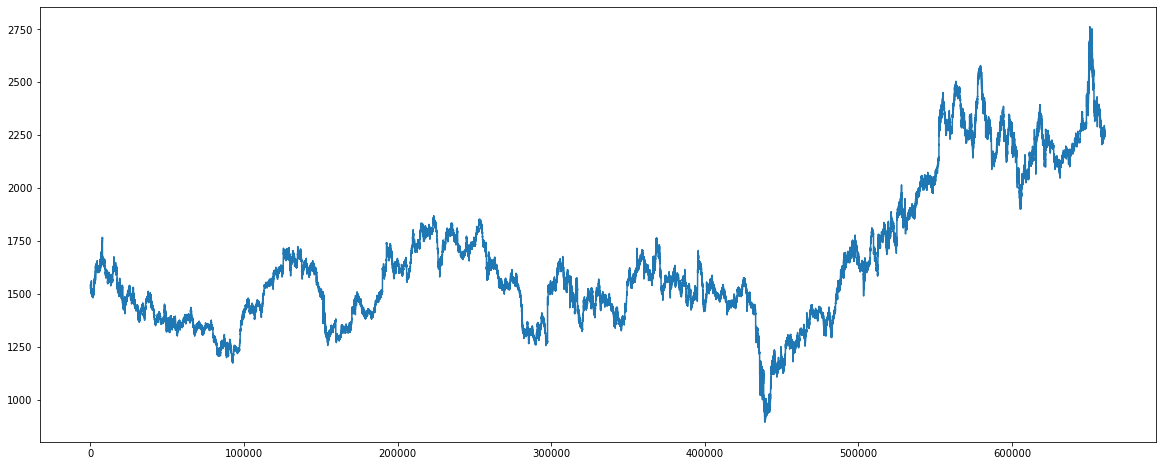

In [6]:
plt.figure(figsize=(20,8))
plt.plot(df1)

In [7]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
training_size=int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [9]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step=100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [12]:
X_train.shape[1]

100

In [13]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation = 'relu', return_sequences = True,  input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-traina

In [15]:
model.fit(X_train, y_train, epochs=20, batch_size=64, shuffle=False)

Epoch 1/20
8256/8256 [==============================] - 727s 88ms/step - loss: 2.7116e-04
Epoch 2/20
8256/8256 [==============================] - 709s 86ms/step - loss: 3.2249e-04
Epoch 3/20
8256/8256 [==============================] - 708s 86ms/step - loss: 4.1341e-04
Epoch 4/20
8256/8256 [==============================] - 707s 86ms/step - loss: 4.6885e-04
Epoch 5/20
8256/8256 [==============================] - 710s 86ms/step - loss: 4.8070e-04
Epoch 6/20
8256/8256 [==============================] - 709s 86ms/step - loss: 4.8870e-04
Epoch 7/20
8256/8256 [==============================] - 709s 86ms/step - loss: 4.9942e-04
Epoch 8/20
8256/8256 [==============================] - 709s 86ms/step - loss: 5.3843e-04
Epoch 9/20
8256/8256 [==============================] - 702s 85ms/step - loss: 5.0717e-04
Epoch 10/20
8256/8256 [==============================] - 691s 84ms/step - loss: 4.9752e-04
Epoch 11/20
8256/8256 [==============================] - 693s 84ms/step - loss: 5.3583e-04
Epoch 12

In [16]:
test_predict = model.predict(X_test)

4126/4126 [==============================] - 84s 20ms/step


In [17]:
print(f'MSE {mean_squared_error(y_test, test_predict)}')
print(f'R2 {r2_score(y_test, test_predict)}')

MSE 0.027505147903533013
R2 -2.400493943297334


In [18]:
test_predict= scaler.inverse_transform(test_predict)
train_predict = model.predict(X_train)
train_predict=scaler.inverse_transform(train_predict)

16511/16511 [==============================] - 332s 20ms/step


In [19]:
look_back = 100

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

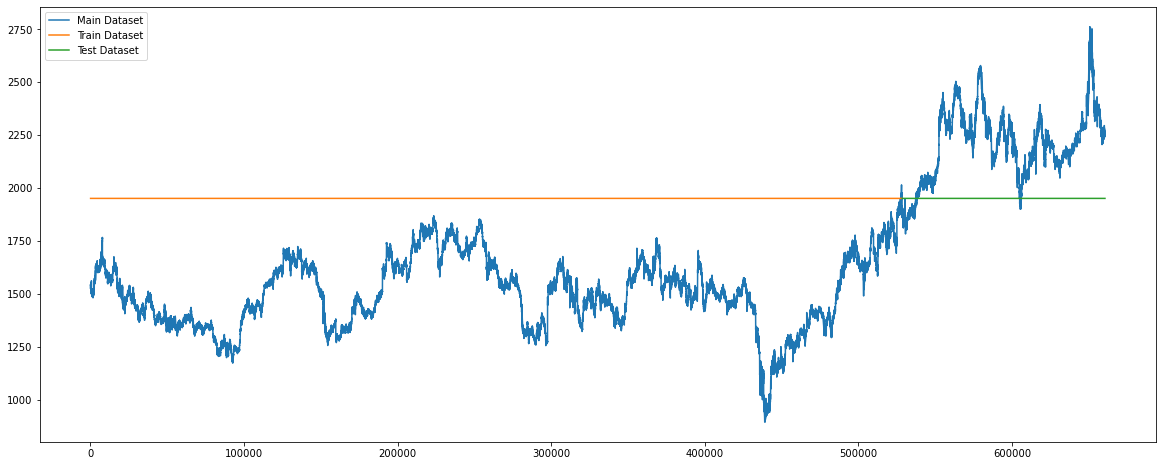

In [20]:
plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(df1), label = 'Main Dataset')
plt.plot(trainPredictPlot, label = 'Train Dataset')
plt.plot(testPredictPlot, label = 'Test Dataset')
plt.legend()

In [21]:
x_input = df1[len(df1)-100:].reshape(1,-1)

In [22]:
x_input = x_input.reshape((1,100,1))
y_predict = model.predict(x_input, verbose = 0)
next_day_value = scaler.inverse_transform(y_predict)

In [23]:
next_day_value

array([[1951.2045]], dtype=float32)